In [110]:
%matplotlib inline


The eigenfaces example: chaining PCA and SVMs
=============================================

The goal of this example is to show how an unsupervised method and a
supervised one can be chained for better prediction. It starts with a
didactic but lengthy way of doing things, and finishes with the
idiomatic approach to pipelining in scikit-learn.

Here we'll take a look at a simple facial recognition example. Ideally,
we would use a dataset consisting of a subset of the `Labeled Faces in
the Wild <http://vis-www.cs.umass.edu/lfw/>`__ data that is available
with :func:`sklearn.datasets.fetch_lfw_people`. However, this is a
relatively large download (~200MB) so we will do the tutorial on a
simpler, less rich dataset. Feel free to explore the LFW dataset.



In [111]:
from sklearn import datasets
faces = datasets.fetch_olivetti_faces()
faces.data.shape

(400, 4096)

In [112]:
# description du dataset
faces.keys()
print(faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

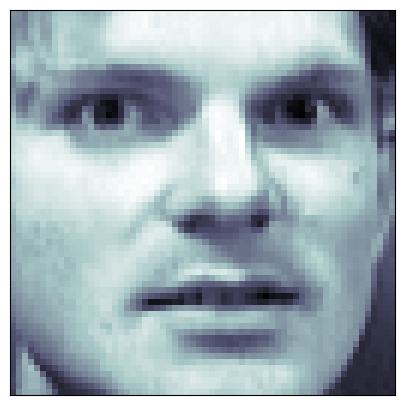

In [113]:
# Affichage d'une image tirée au sort
import numpy as np
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(5, 5))

rand = np.random.randint(0, 400)

ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
ax.imshow(faces.images[rand], cmap=plt.cm.bone)

Let's visualize these faces to see what we're working with



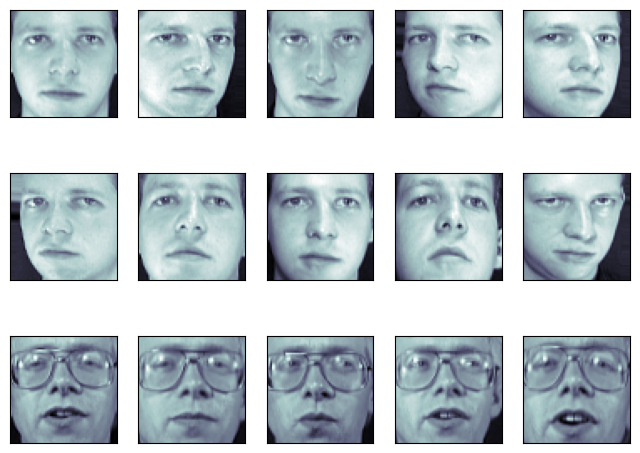

In [114]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(faces.images[i], cmap=plt.cm.bone)

.. tip::

   Note is that these faces have already been localized and scaled to a
   common size. This is an important preprocessing piece for facial
   recognition, and is a process that can require a large collection of
   training data. This can be done in scikit-learn, but the challenge is
   gathering a sufficient amount of training data for the algorithm to work.
   Fortunately, this piece is common enough that it has been done. One good
   resource is
   `OpenCV <https://docs.opencv.org/2.4/modules/contrib/doc/facerec/facerec_tutorial.html>`__,
   the *Open Computer Vision Library*.

We'll perform a Support Vector classification of the images. We'll do a
typical train-test split on the images:



In [115]:
# Faire un split hold-out avec 80% d'entraînement avec stratas
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, random_state=0,
                                                    test_size=0.20, stratify=faces.target)

print(X_train.shape, X_test.shape)

(320, 4096) (80, 4096)


In [116]:
# Nous vérifions que les classes des dataset d'entraînement et de test sont équilibrées
unique_values, counts = np.unique(y_train, return_counts=True)
unique_values, counts
# Nous voyons que nous obtenons bien la meme qté de tuples pour chaque classe i.e. 8/10
# Dimension des jeux 320 tuples pour l'entraînement et 80 pour le test



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], dtype=int64))

In [117]:

def pl(a, b, txt, data):
    plt.plot(range(a, b), data, marker='o') 
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(txt)
    plt.grid(True)
    plt.show()

In [118]:
# Nous allons tenter une classification tel que demandé au point #3 du laboratoire
# Avec respectivement KNN, régression logistique et SVM. Nous noterons les résultats et les
# comparerons avec une méthode ACP par la suite.
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def knn_clf(X_train, y_train, X_test, y_test):
    hist = []
    best_accu=0
    nk=0
    for k in range(1, 55):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accu = metrics.accuracy_score(y_test, y_pred)
        hist.append(accu)
        if accu > best_accu:
            best_accu = accu
            nk=k
    #pl(1, 55, "accu", hist)
    #print(f"Accu: {best_accu:.2f} best K: {nk}")
    return best_accu


In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

def log_reg_clf(X_train, y_train, X_test, y_test):
    logreg = LogisticRegression(random_state=42)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
    accu = metrics.accuracy_score(y_test, y_pred)
    #print(f"Accu: {accu:.2f}")
    return accu


In [120]:
from sklearn import svm
from sklearn import metrics

def svc_clf(X_train, y_train, X_test, y_test):
    clf = svm.SVC(C=10.0, kernel='linear')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accu =metrics.accuracy_score(y_test, y_pred)
    
    #print(f"Accu: {accu:.2f}")
    return accu


In [121]:
acc_1 = svc_clf(X_train, y_train, X_test, y_test)
acc_2 =knn_clf(X_train, y_train, X_test, y_test)
acc_3 = log_reg_clf(X_train, y_train, X_test, y_test)
print(f"accu svc:{acc_1}")
print(f"accu knn:{acc_2}")
print(f"accu log reg:{acc_3}")

accu svc:0.95
accu knn:0.95
accu log reg:0.9375


C:\Users\Julien\miniconda3\envs\PCD\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Preprocessing: Principal Component Analysis
-------------------------------------------

1850 dimensions is a lot for SVM. We can use PCA to reduce these 1850
features to a manageable size, while maintaining most of the information
in the dataset.



In [122]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=150, whiten=True)
pca.fit(X_train)

PCA(n_components=150, whiten=True)

One interesting part of PCA is that it computes the "mean" face, which
can be interesting to examine:



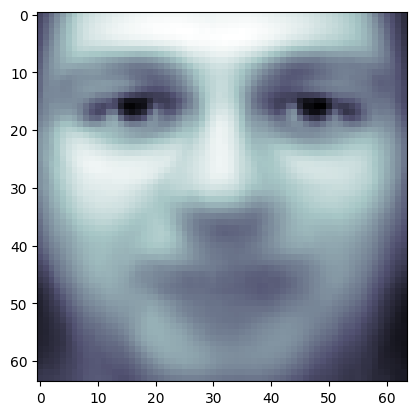

In [123]:
plt.imshow(pca.mean_.reshape(faces.images[0].shape),
           cmap=plt.cm.bone)

The principal components measure deviations about this mean along
orthogonal axes.



In [124]:
print(pca.components_.shape)

(150, 4096)


It is also interesting to visualize these principal components:



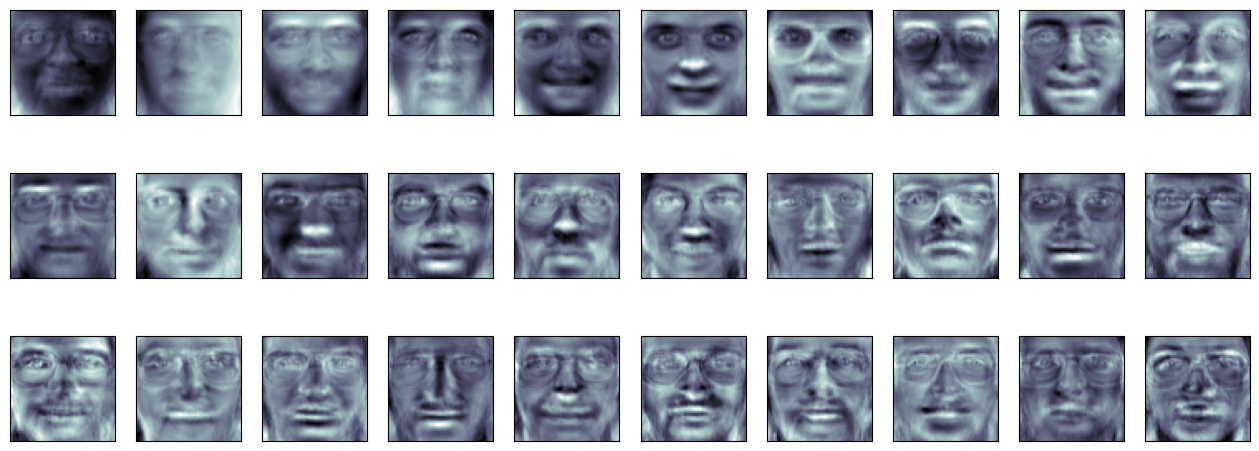

In [125]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)

The components ("eigenfaces") are ordered by their importance from
top-left to bottom-right. We see that the first few components seem to
primarily take care of lighting conditions; the remaining components
pull out certain identifying features: the nose, eyes, eyebrows, etc.

With this projection computed, we can now project our original training
and test data onto the PCA basis:



In [126]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)

(320, 150)


In [127]:
print(X_test_pca.shape)

(80, 150)


These projected components correspond to factors in a linear combination
of component images such that the combination approaches the original
face.

Doing the Learning: Support Vector Machines
-------------------------------------------

Now we'll perform support-vector-machine classification on this reduced
dataset:



In [ ]:
# Nous allons répeter ici les expériences de classification après l'ACP
# knn -- 112
# logreg
# svc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


i=1
best_c=0
best_a=0
hist=[]

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

for k in range(1, 100):
    pca = decomposition.PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train_sc)
    X_test_pca = pca.transform(X_test_sc)
    
    acc = knn_clf(X_train_pca, y_train, X_test_pca, y_test)
    hist.append(acc)
    if acc > best_a:
        best_a = acc
        i=k
    print(k)
    
print(best_a)
print(f"n comp:{i}")
pl(1, 100, "accu", hist)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


i=1
best_c=0
best_a=0
hist=[]



for k in range(1, 100):
    pca = decomposition.PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train_sc)
    X_test_pca = pca.transform(X_test_sc)
    
    acc = svc_clf(X_train_pca, y_train, X_test_pca, y_test)
    hist.append(acc)
    if acc > best_a:
        best_a = acc
        i=k
    print(k)
    
print(best_a)
print(f"n comp:{i}")
pl(1, 100, "accu", hist)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


i=1
best_c=0
best_a=0
hist=[]



for k in range(1, 100):
    pca = decomposition.PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train_sc)
    X_test_pca = pca.transform(X_test_sc)
    
    acc = log_reg_clf(X_train_pca, y_train, X_test_pca, y_test)
    hist.append(acc)
    if acc > best_a:
        best_a = acc
        i=k
    print(k)
    
print(best_a)
print(f"n comp:{i}")
pl(1, 100, "accu", hist)

In [ ]:
pca = decomposition.PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

acc_svc = svc_clf(X_train_pca, y_train, X_test_pca, y_test)
acc_knn = knn_clf(X_train_pca, y_train, X_test_pca, y_test)
acc_log = log_reg_clf(X_train_pca, y_train, X_test_pca, y_test)

print(f"accuracy svc:{acc_svc}")
print(f"accuracy knn:{acc_knn}")
print(f"accuracy log reg:{acc_log}")

In [ ]:
from sklearn import svm
clf = svm.SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train)

Finally, we can evaluate how well this classification did. First, we
might plot a few of the test-cases with the labels learned from the
training set:



In [ ]:
import numpy as np
fig = plt.figure(figsize=(8, 6))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)
    y_pred = clf.predict(X_test_pca[i, np.newaxis])[0]
    color = ('black' if y_pred == y_test[i] else 'red')
    ax.set_title(y_pred, fontsize='small', color=color)

The classifier is correct on an impressive number of images given the
simplicity of its learning model! Using a linear classifier on 150
features derived from the pixel-level data, the algorithm correctly
identifies a large number of the people in the images.

Again, we can quantify this effectiveness using one of several measures
from :mod:`sklearn.metrics`. First we can do the classification
report, which shows the precision, recall and other measures of the
"goodness" of the classification:



In [ ]:
from sklearn import metrics
y_pred = clf.predict(X_test_pca)
print(metrics.classification_report(y_test, y_pred))

Another interesting metric is the *confusion matrix*, which indicates
how often any two items are mixed-up. The confusion matrix of a perfect
classifier would only have nonzero entries on the diagonal, with zeros
on the off-diagonal:



In [ ]:
print(metrics.confusion_matrix(y_test, y_pred))

Pipelining
----------

Above we used PCA as a pre-processing step before applying our support
vector machine classifier. Plugging the output of one estimator directly
into the input of a second estimator is a commonly used pattern; for
this reason scikit-learn provides a ``Pipeline`` object which automates
this process. The above problem can be re-expressed as a pipeline as
follows:



In [ ]:
from sklearn.pipeline import Pipeline
clf = Pipeline([('pca', decomposition.PCA(n_components=150, whiten=True)),
                ('svm', svm.LinearSVC(C=1.0))])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(metrics.confusion_matrix(y_pred, y_test))
plt.show()

A Note on Facial Recognition
----------------------------

Here we have used PCA "eigenfaces" as a pre-processing step for facial
recognition. The reason we chose this is because PCA is a
broadly-applicable technique, which can be useful for a wide array of
data types. Research in the field of facial recognition in particular,
however, has shown that other more specific feature extraction methods
are can be much more effective.

